In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import DistanceMetric
from math import radians
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx
from gurobipy import *
import osmnx as ox
ox.config(use_cache=True, log_console=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
mat = pd.read_hdf("distance_albstadt_mat.h5", "mat")
mat1 = pd.read_hdf("time_albstadt_mat.h5", "mat1")

In [3]:
# Sample Customers from osmnx

# Define Customer N and Demand per
customers = 100
demand_per_customer = 5
avg_basket_size = 80

# Function to create a Customer Index List
def createList_C(r1, r2):
    return list(['C%d'%x for x in range(r1, r2+1)])

# Get all nodes in Würzburg from OSMNX which will be used to sample a certain amount of customers
D = ox.graph_from_place("Albstadt, Germany", network_type = "drive")
Ds = ox.utils_graph.get_largest_component(D, strongly = True)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(Ds)

# Create nodes_df which is the basis for our customer df
nodes_df = gdf_nodes[["y", "x"]].copy()
nodes_df.columns = ["lat", "lon"]

# Remove Troublemaker Nodes
remove_nodes = [323283295, 54430983, 54431056, 54431063]

nodes_df = nodes_df.drop(index = remove_nodes)


#Sample from nodes_df
sample_nodes_df = nodes_df.sample(n = customers, random_state= 3)


#DF Manipulation
C_ID = createList_C(1,customers)
osmid = list(sample_nodes_df.index.values)
sample_nodes_df = sample_nodes_df.rename(index=dict(zip(osmid,C_ID)))
sample_nodes_df.index.name = "C_ID"
sample_nodes_df["osmid"] = osmid

#Create final demand column for customer DF

tri_demand = np.random.default_rng(2).triangular(10, 50, 85, customers)
tri_demand = tri_demand.round(0)
tri_demand = tri_demand.tolist()


#mylist = [demand_per_customer] * customers

set_of_all_customers = sample_nodes_df.copy()
# Add Demand column from the newly created list
set_of_all_customers['Demand_C'] = tri_demand
# Sort the df by osmid, this needs to be done for renaming purposes in the dist_matrix
set_of_all_customers = set_of_all_customers.sort_values(by=["osmid"])
# New index C1-C2 etc.
set_of_all_customers.reset_index(drop=True, inplace=True)
set_of_all_customers.index = C_ID
set_of_all_customers.index.names = ["C_ID"]
# Create Nodes_S for joining and plotting later
Nodes_S = set_of_all_customers["osmid"].tolist()
# Create index J for model building
J = set_of_all_customers.index.values
set_of_all_customers.head()

,lat,lon,osmid,Demand_C
C_ID,,,,
C1,48.286087,9.002014,54431070,40.0
C2,48.213757,8.959233,95742338,64.0
C3,48.210818,9.024998,248189232,27.0
C4,48.219939,9.008871,251566597,50.0
C5,48.207644,9.022009,254316962,53.0


In [4]:
sum(set_of_all_customers["Demand_C"])

4709.0

In [5]:
# Number of Candidate DCs chosen from Facility Location Model
DC_N = 1
fixed_cost_factor = 0.08

# List Creator for DCs
def createList_DC(r1, r2):
    return list(['DC%d'%x for x in range(r1, r2+1)])

#create an index
DC_ID = createList_DC(1, DC_N)

#Gi = fixed cost for establishing depot i
fixed_cost_DC = [(customers * avg_basket_size) * fixed_cost_factor] * DC_N 

#Maximum Throughput at depot i = Vi
capacity_DC = [10000] * DC_N

#Variable Warehousing Cost (Picking)
varCost_DC = [0.287, 0.287, 0.287, 0.287]

# Candidate DCs from FLM
#-30333819; Coordinates: 48.2907856, 9.0651417 
#-84418680; Coordinates: 48.2369097, 9.0841059
#-266217309; Coordinates: 48.246831, 8.9053683 
#-9146789165; Coordinates: 48.2961436, 8.9386563 


#Position of the DCs
lat_DC = [48.2369097, 48.2907856, 48.246831, 48.2961436]
lon_DC = [9.0841059, 9.0651417, 8.9053683 , 8.9386563 ]

# Osmid of the Dcs
osmid = [84418680, 30333819, 266217309, 9146789165]

dc_tuples = list(zip(DC_ID, fixed_cost_DC, capacity_DC, varCost_DC, lat_DC, lon_DC, osmid))

set_of_all_DC = pd.DataFrame(dc_tuples, columns = ["DC_ID", "fixed_cost_DC", "capacity_DC", "varCost_DC", "lat", "lon", "osmid"])
set_of_all_DC.set_index("DC_ID", inplace = True)

# Define Index I for model building
I = set_of_all_DC.index.values

# DC_S
DC_S = set_of_all_DC["osmid"].values.tolist()

set_of_all_DC

,fixed_cost_DC,capacity_DC,varCost_DC,lat,lon,osmid
DC_ID,,,,,,
DC1,640.0,10000,0.287,48.23691,9.084106,84418680


In [6]:
Nodes_S = set_of_all_customers["osmid"].tolist()
Nodes_S1 = DC_S + Nodes_S

In [7]:
# Construct set of all vehicles K

#Vehicle Count
V_N = 3

# Vehicle List Creator
def createList_V(r1, r2):
    return list(['V_%d'%x for x in range(r1, r2+1)])

# create index
V_ID = createList_V(1, V_N)

# Vehicle Capacity Qk
capacity_V = [4000] * V_N

# fixed cost of using Vehicle Fk
fixed_cost_V = [22.5] * V_N

v_tuples = list(zip(V_ID, capacity_V, fixed_cost_V))

set_of_all_vehicles = pd.DataFrame(v_tuples, columns = ["V_ID", "capacity_V", "fixed_cost_V"])
set_of_all_vehicles.set_index("V_ID", inplace=True)
K = set_of_all_vehicles.index.values
set_of_all_vehicles

,capacity_V,fixed_cost_V
V_ID,,
V_1,4000,22.5
V_2,4000,22.5
V_3,4000,22.5


In [8]:
# Have to somehow adapt this code so that it works with C_IDs and DC_IDs. Map osmids to the DC/C_IDs, so we can have a distance matrix with those Indexs

# Join Distances for the sampled nodes from our Initial Distance Matrix for all nodes 
dist_matrix_d = pd.DataFrame(index=Nodes_S1)
# Rename the index for the join with the distance matrix
dist_matrix_d = dist_matrix_d.rename_axis("osmid")
# Join new empty dist_matrix with filled matrix for every chosen node
dist_matrix_d = dist_matrix_d.merge(mat, left_index=True, right_index=True)
dist_matrix_d = dist_matrix_d[dist_matrix_d.columns.intersection(Nodes_S1)]
#Rename Columns to fit the order of Nodes_S1 = DCs first then Customers. Index and columns have to match in position
dist_matrix_d = dist_matrix_d.reindex(columns=Nodes_S1)

# Have to replace column names and index values with more paletable values (osmids could confuse, need DC1 C1 etc.). Use the I and J arrays from Customer and DC Dataframes to form a list
nn = np.concatenate((I,J), axis=None)
new_colnames = nn.tolist()
dist_matrix_d.columns = new_colnames
dist_matrix_d.index = new_colnames
dist_matrix_d 

,DC1,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
DC1,0.0,11385.0,11621.7,6498.2,8596.1,7268.3,6597.8,7550.0,7403.2,7049.1,...,7386.0,15440.7,7458.8,6791.2,7789.0,7781.3,6210.0,12858.3,9372.3,10355.5
C1,11262.1,0.0,12570.6,9465.7,11141.2,9871.0,9565.3,10152.6,9948.3,9633.3,...,7105.0,16035.4,10061.5,6664.7,4018.8,4346.8,8983.3,8344.7,5674.4,6203.7
C2,11510.1,12323.1,0.0,5170.8,5345.2,5110.9,5190.4,4339.6,4218.4,4783.5,...,8755.1,4002.5,4600.0,7507.1,8672.9,8554.5,5707.1,5986.5,7226.1,9045.0
C3,6419.4,9464.3,5190.4,0.0,2435.8,770.1,99.6,1051.7,1049.7,550.9,...,4192.9,9009.3,960.6,2944.8,5556.2,5473.4,731.7,9536.8,6664.1,8047.6
C4,8460.1,10942.3,5345.3,2412.7,0.0,2818.0,2358.0,3099.6,1386.1,1951.1,...,5670.9,9164.3,1767.6,4422.8,7034.2,6951.4,2634.0,9691.7,8142.1,9525.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C96,7825.9,4320.6,8594.2,5513.6,7189.0,5918.8,5613.2,6200.5,5996.1,5681.2,...,3077.9,12058.9,6109.3,2712.5,367.8,0.0,5031.1,5184.0,1697.9,2681.2
C97,6191.4,8979.5,5765.0,913.4,2739.4,1511.4,1013.1,1793.1,1546.5,1231.6,...,3708.1,9584.0,1701.9,2460.0,5071.3,4988.6,0.0,9776.9,6179.3,7562.8
C98,12732.7,8344.7,5986.5,9506.3,9680.8,9698.5,9525.9,9182.2,8554.0,9119.0,...,7298.2,9451.2,8935.6,7478.9,5262.7,5144.3,9797.5,0.0,3815.9,5634.8
C99,9246.7,5426.9,7226.1,6682.3,8357.8,7087.6,6781.9,7369.2,7164.9,6849.9,...,3700.6,10690.8,7278.1,3881.3,1776.7,1658.3,6199.9,3815.9,0.0,2548.0


In [10]:
lol = dist_matrix_d.index.values
lol = lol.tolist()
len(lol)

500

In [11]:
new_list = [item for item in Nodes_S1 if item not in lol]
new_list


[323283295]

In [9]:
dist_matrix = dist_matrix_d * 0.00018
dist_matrix.head()

,DC1,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
DC1,0.000000,2.049300,2.091906,1.169676,1.547298,1.308294,1.187604,1.359000,1.332576,1.268838,...,1.329480,2.779326,1.342584,1.222416,1.402020,1.400634,1.117800,2.314494,1.687014,1.863990
C1,2.027178,0.000000,2.262708,1.703826,2.005416,1.776780,1.721754,1.827468,1.790694,1.733994,...,1.278900,2.886372,1.811070,1.199646,0.723384,0.782424,1.616994,1.502046,1.021392,1.116666
C2,2.071818,2.218158,0.000000,0.930744,0.962136,0.919962,0.934272,0.781128,0.759312,0.861030,...,1.575918,0.720450,0.828000,1.351278,1.561122,1.539810,1.027278,1.077570,1.300698,1.628100
C3,1.155492,1.703574,0.934272,0.000000,0.438444,0.138618,0.017928,0.189306,0.188946,0.099162,...,0.754722,1.621674,0.172908,0.530064,1.000116,0.985212,0.131706,1.716624,1.199538,1.448568
C4,1.522818,1.969614,0.962154,0.434286,0.000000,0.507240,0.424440,0.557928,0.249498,0.351198,...,1.020762,1.649574,0.318168,0.796104,1.266156,1.251252,0.474120,1.744506,1.465578,1.714608


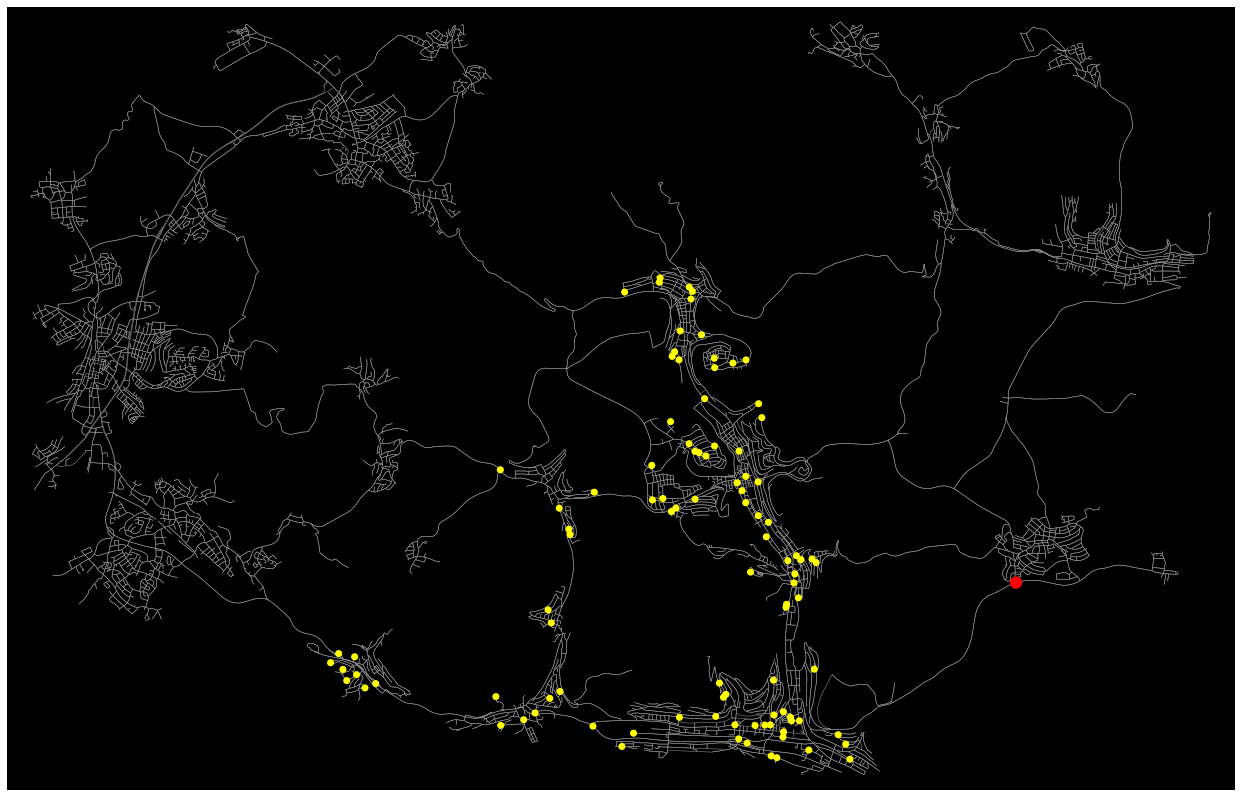

In [26]:
G = ox.graph_from_bbox(north = 48.33122, south =48.203926, east = 9.142871, west = 8.834133, network_type = "drive")
Gs = ox.utils_graph.get_largest_component(G, strongly = True)


nodes, edges = ox.graph_to_gdfs(Gs, nodes=True, edges=True)

ns = []
for node in Gs.nodes():
    if node in DC_S:
        ns.append(150)
    elif node in Nodes_S:
        ns.append(50)
    else:
        ns.append(0)
        
nc = []
for node in Gs.nodes():
    if node in DC_S: 
        nc.append("red")
    elif node in Nodes_S:
        nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(Gs, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [32]:
listlol = mat1[84418680].tolist()
listlol.count(0)

1

In [10]:
# Join Travel Times for the sampled nodes from our Time Matrix for all nodes 
time_matrix_t = pd.DataFrame(index=Nodes_S1)
# Rename the index for the join with the time matrix
time_matrix_t = time_matrix_t.rename_axis("osmid")
# Join new empty time_matrix with filled matrix for every chosen node
time_matrix_t = time_matrix_t.merge(mat1, left_index=True, right_index=True)
time_matrix_t = time_matrix_t[time_matrix_t.columns.intersection(Nodes_S1)]
#time_matrix_t.tail(25)
#Rename Columns to fit the order of Nodes_S1 = DCs first then Customers. Index and columns have to match in position
time_matrix_t = time_matrix_t.reindex(columns=Nodes_S1)

nn = np.concatenate((I,J), axis=None)
new_colnames = nn.tolist()
time_matrix_t.columns = new_colnames
time_matrix_t.index = new_colnames
time_matrix_t

,DC1,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
DC1,0.0,438.0,612.0,460.9,575.8,490.5,472.2,506.1,465.9,472.2,...,473.3,801.3,481.5,414.3,533.9,521.7,416.4,832.1,640.5,710.2
C1,434.1,0.0,636.6,585.5,698.2,612.9,596.8,628.5,588.3,594.6,...,504.3,825.9,603.9,445.3,266.1,269.8,538.8,403.1,361.2,291.6
C2,604.5,635.9,0.0,171.0,276.7,198.4,182.3,214.0,166.8,173.1,...,412.6,189.3,182.4,302.1,503.5,491.3,234.5,356.7,418.1,539.1
C3,461.0,588.5,173.3,0.0,137.1,51.8,11.3,67.4,27.2,33.5,...,273.0,362.6,42.8,162.5,363.9,351.7,63.5,427.4,470.5,540.2
C4,569.2,692.8,277.6,135.7,0.0,163.1,147.0,178.7,109.9,137.8,...,377.3,466.9,147.1,266.8,468.2,456.0,199.2,531.7,574.8,644.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C96,519.0,275.9,496.8,347.9,460.6,375.3,359.2,390.9,350.7,357.0,...,266.7,686.1,366.3,207.7,45.5,0.0,301.2,337.5,138.1,207.8
C97,416.4,540.0,237.6,64.3,201.4,116.1,75.6,131.7,91.5,97.8,...,224.5,426.9,107.1,114.0,315.4,303.2,0.0,491.7,422.0,491.7
C98,827.5,402.4,356.7,425.1,530.8,452.5,436.4,468.1,420.9,427.2,...,596.3,546.0,436.5,537.3,352.6,344.9,488.6,0.0,239.0,360.0
C99,649.2,355.6,418.1,478.1,590.8,505.5,489.4,521.1,480.9,487.2,...,396.9,607.4,496.5,337.9,153.2,145.5,431.4,239.0,0.0,200.6


In [44]:
listlol = mat1[54431070].tolist()
listlol.count(0)

1

In [ ]:
offenders: 54430983, 54431056, 54431063

In [25]:
asdasd = [30333819, 54430983, 54431056, 54431063]

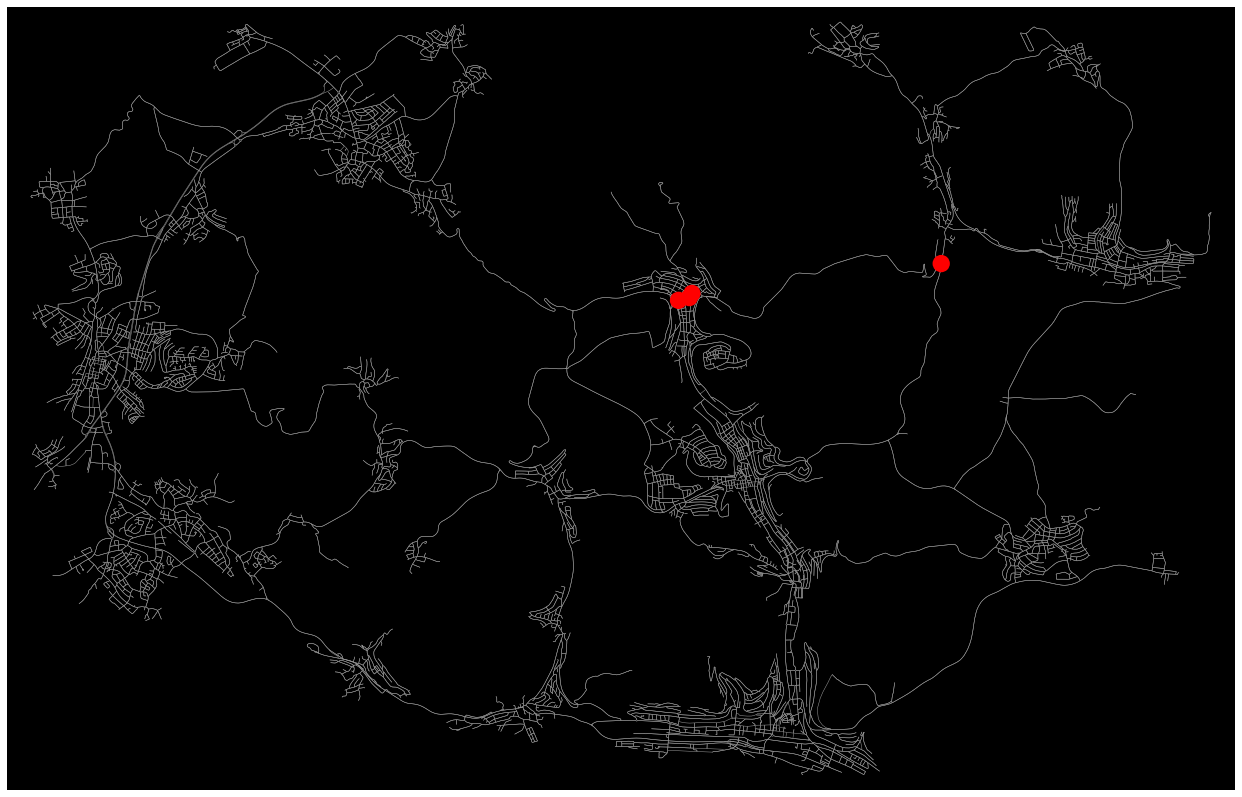

In [26]:
# Sanity Check
ns = []
for node in Gs.nodes():
    if node in asdasd:
        ns.append(300)
    #elif node in Node_C1:
        #ns.append(40)
    else:
        ns.append(0)
        
nc = []
for node in Gs.nodes():
    if node in asdasd: 
        nc.append("red")
    #elif node in Node_C1:
     #   nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(Gs, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [11]:
# Time Factor for traffic
time_matrix_t = time_matrix_t * 1.8
# Add Service Time to the routes for every route from Customer to Customer or DC to customer (but not from Customer to DC)
service_time = 120 # 120 Seconds Service Time for a delivery should be reasonable
time_matrix_t[len(DC_S):len(DC_S)+len(Nodes_S)] = time_matrix_t[len(DC_S):len(DC_S)+len(Nodes_S)] + service_time
time_matrix_t.head()

,DC1,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
DC1,0.00,788.40,1101.60,829.62,1036.44,882.90,849.96,910.98,838.62,849.96,...,851.94,1442.34,866.70,745.74,961.02,939.06,749.52,1497.78,1152.90,1278.36
C1,901.38,120.00,1265.88,1173.90,1376.76,1223.22,1194.24,1251.30,1178.94,1190.28,...,1027.74,1606.62,1207.02,921.54,598.98,605.64,1089.84,845.58,770.16,644.88
C2,1208.10,1264.62,120.00,427.80,618.06,477.12,448.14,505.20,420.24,431.58,...,862.68,460.74,448.32,663.78,1026.30,1004.34,542.10,762.06,872.58,1090.38
C3,949.80,1179.30,431.94,120.00,366.78,213.24,140.34,241.32,168.96,180.30,...,611.40,772.68,197.04,412.50,775.02,753.06,234.30,889.32,966.90,1092.36
C4,1144.56,1367.04,619.68,364.26,120.00,413.58,384.60,441.66,317.82,368.04,...,799.14,960.42,384.78,600.24,962.76,940.80,478.56,1077.06,1154.64,1280.10


In [12]:
time_matrix = time_matrix_t * 0.0045
time_matrix.head()

,DC1,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
DC1,0.00000,3.54780,4.95720,3.73329,4.66398,3.97305,3.82482,4.09941,3.77379,3.82482,...,3.83373,6.49053,3.90015,3.35583,4.32459,4.22577,3.37284,6.74001,5.18805,5.75262
C1,4.05621,0.54000,5.69646,5.28255,6.19542,5.50449,5.37408,5.63085,5.30523,5.35626,...,4.62483,7.22979,5.43159,4.14693,2.69541,2.72538,4.90428,3.80511,3.46572,2.90196
C2,5.43645,5.69079,0.54000,1.92510,2.78127,2.14704,2.01663,2.27340,1.89108,1.94211,...,3.88206,2.07333,2.01744,2.98701,4.61835,4.51953,2.43945,3.42927,3.92661,4.90671
C3,4.27410,5.30685,1.94373,0.54000,1.65051,0.95958,0.63153,1.08594,0.76032,0.81135,...,2.75130,3.47706,0.88668,1.85625,3.48759,3.38877,1.05435,4.00194,4.35105,4.91562
C4,5.15052,6.15168,2.78856,1.63917,0.54000,1.86111,1.73070,1.98747,1.43019,1.65618,...,3.59613,4.32189,1.73151,2.70108,4.33242,4.23360,2.15352,4.84677,5.19588,5.76045


In [13]:
m = Model()

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-23


In [14]:
x = m.addVars([*I,*J],[*I,*J],K, name = "x", vtype=GRB.BINARY)
y = m.addVars(I, name = "y", vtype = GRB.BINARY)
z = m.addVars(I,J, name = "z", vtype = GRB.BINARY)

U = [(l,k) for l in J for k in K]
u = m.addVars(U, name = "u", vtype= GRB.CONTINUOUS)
m.update()

In [15]:
fixedCost_depot = quicksum(y[i] * set_of_all_DC.loc[i].fixed_cost_DC for i in I)

variableCosts_transp = quicksum([(dist_matrix.loc[i,j] + time_matrix.loc[i,j]) * x[i,j,k] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])

variableCosts_DC = quicksum(set_of_all_DC.loc[i].varCost_DC * z[i,j] * set_of_all_customers.loc[j].Demand_C for j in J for i in I)

fixedCost_vehicle = quicksum(x[i,j,k] * set_of_all_vehicles.loc[k].fixed_cost_V for i in I for j in J for k in K if i!=j)

In [16]:
obj = fixedCost_depot + variableCosts_transp + variableCosts_DC + fixedCost_vehicle
m.setObjective(obj, GRB.MINIMIZE)

In [17]:
for j in J:
    m.addConstr(quicksum(x[i,j,k] for i in [*I,*J] for k in K if i!=j) == 1)
    
for k in K:
    m.addConstr(quicksum(set_of_all_customers.loc[j].Demand_C * x[i,j,k] for i in [*I,*J] for j in J if i!=j) <= set_of_all_vehicles.loc[k].capacity_V)
    
for l in J:
    for j in J:
        if l!=j:
            for k in K:
                m.addConstr(u[l,k] - u[j,k] + (len(set_of_all_customers) * x[l,j,k]) <= len(set_of_all_customers) -1)
                
for i in [*I,*J]:
    for k in K:
        m.addConstr(quicksum(x[i,j,k] for j in [*I,*J] if i!=j) - quicksum(x[j,i,k] for j in [*I,*J] if i!=j) == 0)
        

for k in K:
    m.addConstr(quicksum(x[i,j,k] for i in I for j in J) <= 1)
    
for i in I:
    m.addConstr(quicksum(z[i,j] * set_of_all_customers.loc[j].Demand_C for j in J) - (set_of_all_DC.loc[i].capacity_DC * y[i]) <= 0)
    
    
for i in I:
    for j in J:
        for k in K:
            m.addConstr(quicksum(x[i,u,k] + x[u,j,k] for u in [*I,*J]) - z[i,j] <= 1)
            
# New Constraints, to ensure that y[i], the opening of depots works            
for i in I:
    for k in K:
        m.addConstr(quicksum(x[i,j,k] for j in J) <= y[i])
          
# At least one depot has to be opened        
m.addConstr(quicksum(y[i] for i in I) >= 1)

#new zij 
for j in J:
    m.addConstr(quicksum(z[i,j] for i in I) == 1)

for i in I:
    for j in J:
        m.addConstr(quicksum(x[i,j,k] for k in K) <= z[i,j])
        
        
        # Driving Time Constraint, makes sure every vehicle drives 7 hours max a day
        for k in K:
            m.addConstr(quicksum(x[i,j,k] * time_matrix_t.loc[i,j] for i in I for j in J) <= 25200)
        
# New Cap Constraint which should tell the model immediately how many DCs should be opened
# Only works like this if all DCs have the same capacity, if DCs have different capacities just change the "==" to "<="
#m.addConstr(quicksum(y[i] for i in I) <= math.ceil(sum(set_of_all_customers.loc[j].Demand_C for j in J)/(sum(set_of_all_DC.loc[i].capacity_DC for i in I))*DC_N))

In [18]:
m.Params.MIPGap = 0.05
m.Params.Time_Limit = 600
#m.Params.MIPFocus =2
#m.read("tune_time0.prm")
m.update()

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 600


In [19]:
m.Params.LogFile = "gurobi_online_dc.log"
m.update()
m.optimize()

Set parameter LogFile to value "gurobi_online_dc.log"
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 30614 rows, 31004 columns and 271505 nonzeros
Model fingerprint: 0x9ed7f1c9
Variable types: 300 continuous, 30704 integer (30704 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [6e-01, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 505 rows and 401 columns
Presolve time: 0.31s
Presolved: 30109 rows, 30603 columns, 209706 nonzeros
Variable types: 300 continuous, 30303 integer (30303 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Use crossover to convert LP symmetric solution to basic solution...
Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.102477e+03, 357 iterations, 0.15 seconds (0.12 work units)

    Nodes    |

In [20]:
# new cost printer
fixedDC = sum([y[i].X * set_of_all_DC.loc[i].fixed_cost_DC for i in I])
dist_d = sum([x[i,j,k].X *  dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j]).round(1)
time_t = sum([x[i,j,k].X * time_matrix_t.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j]).round(1)
time_cost = sum([x[i,j,k].X * time_matrix.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j]).round(1)
var_dist = sum([x[i,j,k].X *  dist_matrix.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j]).round(1)
fixed_vehicle = sum([x[i,j,k].X * set_of_all_vehicles.loc[k].fixed_cost_V for i in I for j in J for k in K]).round(1)
varDC = sum(set_of_all_DC.loc[i].varCost_DC * z[i,j].X * set_of_all_customers.loc[j].Demand_C for j in J for i in I).round(1)
TotalCost = (time_cost + var_dist + fixed_vehicle + varDC + fixedDC).round(1)
Cost_per_order = (TotalCost / customers).round(1)
var_per_order = (varDC / customers).round(1)
trans_per_order = ((var_dist+time_cost) / customers).round(1)
fixedDC_per_order = (fixedDC / customers).round(1)
Cost_per_item = (TotalCost/sum(set_of_all_customers["Demand_C"])).round(1)
#print("Distance traveled: {}m - in km {} \nTransportation Cost {}€".format(dist_d.round(1), (dist_d/1000).round(1), var_dist.round(1)))
#print("Time elapsed on the routes {}s - in Minutes: {}".format(time_t.round(1), (time_t/60).round(1)))
#print("Time based cost {}€".format(time_cost.round(1)))
#print("Fixed Costs for Depots: {}€ \nVariable Warehousing Cost {}€ \nFixed Vehicle Cost {}€".format(fixedDC, varDC, fixed_vehicle))
#print("Total Cost: {}€".format(TotalCost.round(1)))
#print("Cost per Order {}€".format(Cost_per_order.round(1)))

print("Distance traveled: {}m - in km {} \nTransportation Cost {}€".format(dist_d, (dist_d/1000).round(1), (var_dist+time_cost)))
print("Time elapsed on the routes {}s - in Minutes: {}".format(time_t, (time_t/60).round(1)))
print("Time based cost {}€".format(time_cost))
print("Fixed Costs for Depots: {}€ \nVariable Warehousing Cost {}€ \nFixed Vehicle Cost {}€".format(fixedDC, varDC, fixed_vehicle))
print("Total Cost: {}€".format(TotalCost))
print("Cost per Order {}€".format(Cost_per_order))
print("Variable Cost per Order {}€".format(var_per_order))
print("Transportation Cost per Order {}€".format(trans_per_order))
print("Fixed Warehousing Cost per Order {}€".format(fixedDC_per_order))
print("Total Cost per Item {}€".format(Cost_per_item))

Distance traveled: 181030.0m - in km 181.0 
Transportation Cost 187.79999999999998€
Time elapsed on the routes 34499.3s - in Minutes: 575.0
Time based cost 155.2€
Fixed Costs for Depots: 640.0€ 
Variable Warehousing Cost 1351.5€ 
Fixed Vehicle Cost 45.0€
Total Cost: 2224.3€
Cost per Order 22.2€
Variable Cost per Order 13.5€
Transportation Cost per Order 1.9€
Fixed Warehousing Cost per Order 6.4€
Total Cost per Item 0.5€


In [21]:
# Stop Counter
for k in K:
    r_c = sum([x[i,j,k].X for i in [*I,*J] for j in [*I,*J]])
    time_v = sum([x[i,j,k].X * time_matrix_t.loc[i,j] for i in [*I,*J] for j in [*I,*J]])/60
    print(" Vehicle {} has {} stops on its route and is servicing customers for {} minutes".format(k, r_c, time_v.round(1)))

 Vehicle V_1 has 0.0 stops on its route and is servicing customers for 0.0 minutes
 Vehicle V_2 has 34.0 stops on its route and is servicing customers for 222.8 minutes
 Vehicle V_3 has 68.0 stops on its route and is servicing customers for 352.2 minutes


In [22]:
# Router Order Printer: This one works DC1 (DC has to be hardcoded)
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)
for i, tup in enumerate(selected.select("DC1", "*", "*")):
    k = tup[2]
    print("Route for Vehicle {}: {}".format(k, "DC1"), end = "")
    next_stop = tup[1]
    while next_stop:
        if next_stop == "DC1":
            break
        else:
            print(" -> {}".format(next_stop), end="")
            next_stop = selected.select(next_stop, "*")[0][1]
    print(" -> DC1")
# Total Distances of the routes of each vehicle (includes vehicle that does not start from this DC)
for k in K:
    r_len = sum([x[i,j,k].X * dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J]]) 
    print("Total Distance {}m for Vehicle {}".format(r_len.round(1), k))  

Route for Vehicle V_3: DC1 -> C76 -> C64 -> C87 -> C38 -> C56 -> C57 -> C92 -> C81 -> C82 -> C79 -> C65 -> C78 -> C80 -> C83 -> C2 -> C27 -> C54 -> C26 -> C37 -> C85 -> C59 -> C9 -> C23 -> C4 -> C55 -> C93 -> C8 -> C10 -> C66 -> C90 -> C97 -> C14 -> C70 -> C73 -> C74 -> C48 -> C89 -> C62 -> C91 -> C75 -> C94 -> C45 -> C46 -> C72 -> C71 -> C99 -> C53 -> C100 -> C12 -> C41 -> C40 -> C39 -> C42 -> C20 -> C28 -> C1 -> C18 -> C17 -> C58 -> C98 -> C13 -> C61 -> C60 -> C50 -> C52 -> C44 -> C95 -> DC1
Route for Vehicle V_2: DC1 -> C77 -> C47 -> C67 -> C5 -> C69 -> C6 -> C22 -> C86 -> C30 -> C63 -> C3 -> C84 -> C7 -> C68 -> C88 -> C32 -> C31 -> C15 -> C16 -> C43 -> C51 -> C96 -> C49 -> C29 -> C11 -> C35 -> C36 -> C21 -> C24 -> C25 -> C34 -> C19 -> C33 -> DC1
Total Distance 0.0m for Vehicle V_1
Total Distance 76456.9m for Vehicle V_2
Total Distance 104573.1m for Vehicle V_3


In [23]:
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)

dc_set = set_of_all_DC.reset_index(level = "DC_ID")
dc_set.drop(["fixed_cost_DC", "capacity_DC", "varCost_DC", "lat", "lon"], axis=1, inplace=True)
dc_set.rename(columns={"DC_ID": "ID"}, inplace=True)
dc_set

c_set = set_of_all_customers.reset_index(level = "C_ID")
c_set.drop(["Demand_C", "lat", "lon"], axis=1, inplace=True)
c_set.rename(columns={"C_ID": "ID"}, inplace=True)
c_set.head()

set_join = pd.concat([dc_set, c_set], axis=0)
set_join.head()

tuplol = list(selected)
mydf = pd.DataFrame(tuplol)

mydf.rename(columns={0: "Orig", 1: "Dest", 2: "V"}, inplace=True)
mydf.head()

joiner = pd.merge(mydf, set_join, left_on = "Orig", right_on = "ID")
joiner.drop(["ID"], axis=1, inplace=True)
joiner.rename(columns={"osmid": "orig_osmid"}, inplace=True)
joiner = pd.merge(joiner, set_join, left_on = "Dest", right_on = "ID")
joiner.drop(["ID"], axis=1, inplace=True)
joiner.rename(columns={"osmid": "dest_osmid"}, inplace=True)
joiner.head()

,Orig,Dest,V,orig_osmid,dest_osmid
0,DC1,C76,V_3,84418680,326247633
1,DC1,C77,V_2,84418680,326247661
2,C1,C18,V_3,54431070,259869370
3,C2,C27,V_3,95742338,280531564
4,C3,C84,V_2,248189232,498029261


In [24]:
def shortest_route(orig, dest):
    route = nx.shortest_path(Gs, source=orig, target=dest, weight= "length")                                 
    return route

In [27]:
joiner["route"] = joiner.apply(lambda x: shortest_route(x["orig_osmid"], x["dest_osmid"]), axis=1)
joiner.head()

,Orig,Dest,V,orig_osmid,dest_osmid,route
0,DC1,C76,V_3,84418680,326247633,"[84418680, 248189439, 251662482, 251662441, 25..."
1,DC1,C77,V_2,84418680,326247661,"[84418680, 248189439, 251662482, 251662441, 25..."
2,C1,C18,V_3,54431070,259869370,"[54431070, 54431056, 259869303, 2481828205, 28..."
3,C2,C27,V_3,95742338,280531564,"[95742338, 280532185, 280531593, 280531564]"
4,C3,C84,V_2,248189232,498029261,"[248189232, 366360585, 7282064797, 7282064804,..."


In [28]:
route_list = joiner["route"].tolist()

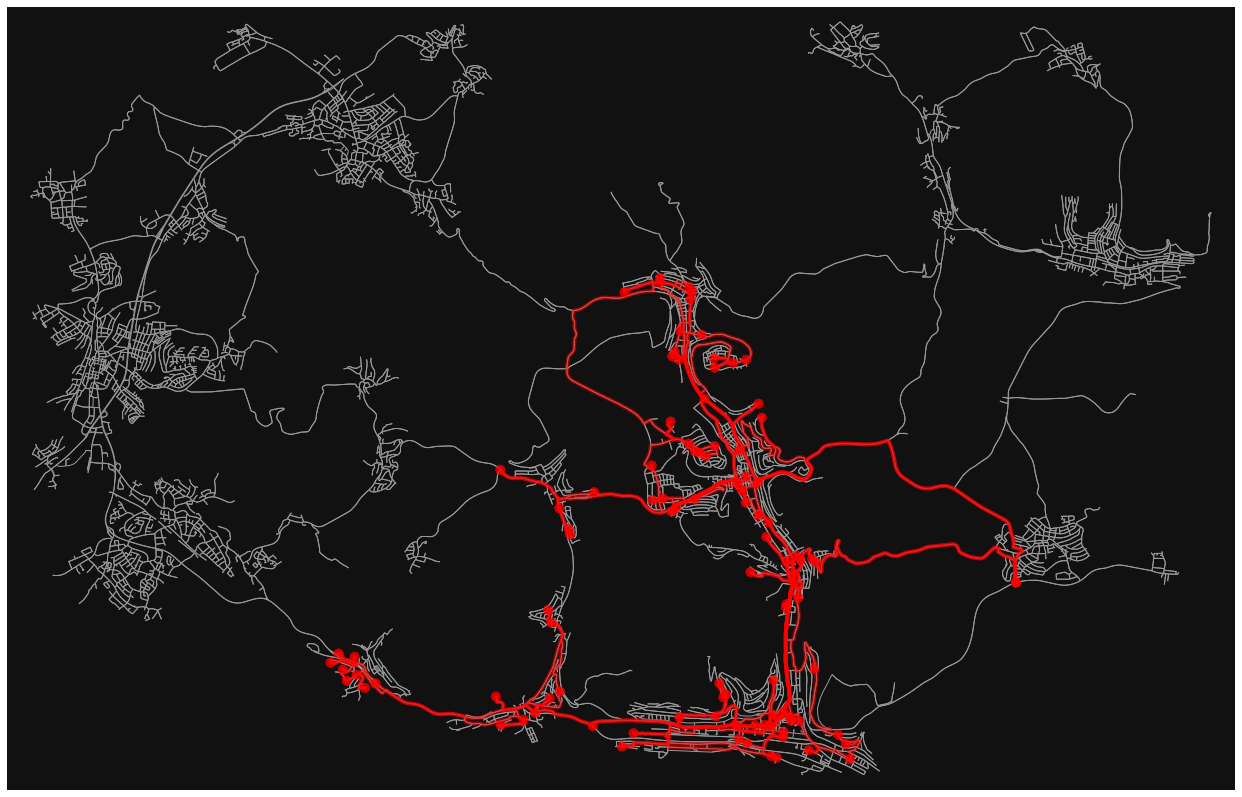

In [29]:
fig, ax = ox.plot_graph_routes(Gs, 
                               route_list, 
                               route_linewidth = 3, node_size = 0, figsize=(22,22))

In [33]:
v2 = joiner[joiner["V"]=="V_2"]
v2_routes = v2["route"].tolist()

v2_nodes_o= v2["orig_osmid"].tolist()
v2_nodes_d= v2["dest_osmid"].tolist()

v2_nodes = v2_nodes_o + v2_nodes_d

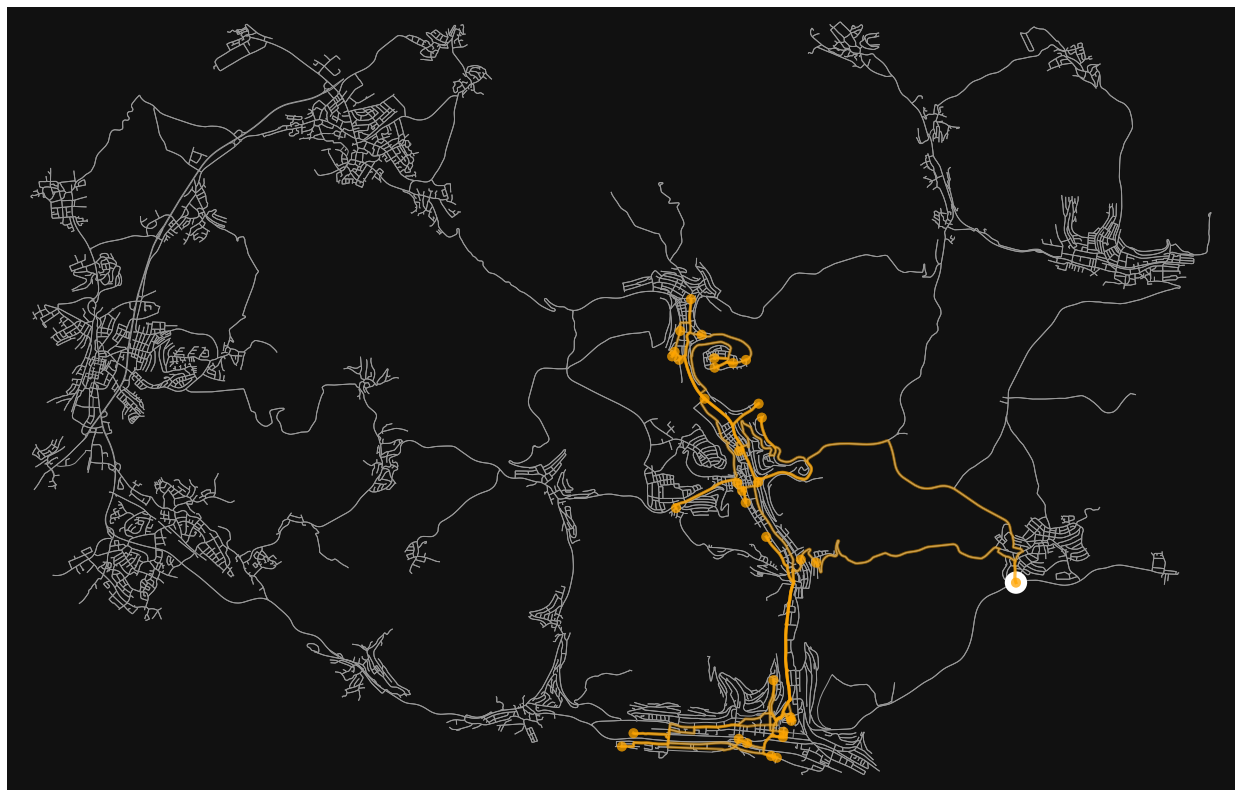

In [34]:
ns = []
for node in G.nodes():
    if node == v2_nodes[0]:
        ns.append(500)
    else:
        ns.append(0)
        
fig, ax = ox.plot_graph_routes(G, 
                               v2_routes, route_colors = "orange", route_linewidths = 3, node_size=ns,
                                  figsize=(22,22))

In [35]:
v2 = joiner[joiner["V"]=="V_3"]
v2_routes = v2["route"].tolist()

v2_nodes_o= v2["orig_osmid"].tolist()
v2_nodes_d= v2["dest_osmid"].tolist()

v2_nodes = v2_nodes_o + v2_nodes_d

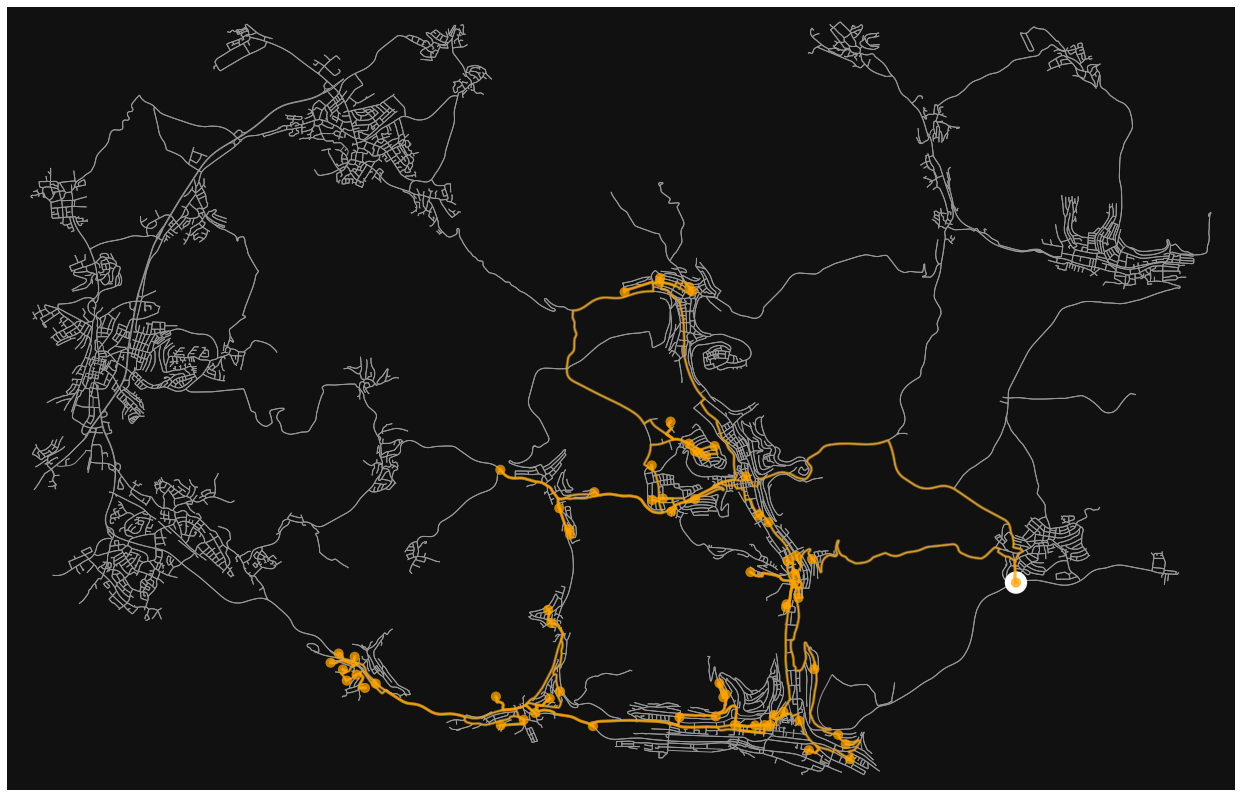

In [36]:
ns = []
for node in G.nodes():
    if node == v2_nodes[0]:
        ns.append(500)
    else:
        ns.append(0)
        
fig, ax = ox.plot_graph_routes(G, 
                               v2_routes, route_colors = "orange", route_linewidths = 3, node_size=ns,
                                  figsize=(22,22))